<a href="https://colab.research.google.com/github/AlexisWu-01/compRobo22_computer_vision/blob/main/gesture_recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This is a working version of transfer learning based on inception_v2_resnet with ability to recognize hand gestures meaning come, left, right, and stop.

# Importing packages and settings

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
import cv2

2022-11-03 17:16:08.796891: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [ ]:
device_name = tf.test.gpu_device_name()
tf.config.set_visible_devices([], 'GPU')
tf.debugging.set_log_device_placement(False)
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0],True)

Metal device set to: AMD Radeon Pro 5600M

systemMemory: 64.00 GB
maxCacheSize: 3.99 GB



2022-11-03 17:16:12.348064: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-03 17:16:12.348796: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-11-03 17:16:12.348842: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-03 17:16:12.349074: I tensorflow/core/common_runtime/pluggable_device/plug

In [ ]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


# Data Preparation

In [ ]:
read_path = '/Users/alexiswu/Desktop/2022Fall/compRobo/computer-vision/hand_sign/'
binary_path = '/Users/alexiswu/Desktop/2022Fall/compRobo/computer-vision/hand_sign_bin/'

## Converting to binary images

These 2 following blocks converts and saves original picture into binary image with customized filter

In [ ]:
def filter_image(rp, sp,filename):
    img = cv2.imread(rp)
    # BGR
    # cv2.imshow('img',img)
    try:
        img = cv2.inRange(img,(82,104,134),(132,167,195))
        cv2.imwrite(sp+filename,img)
    except:
        print('ERROR: '+rp + filename)


In [ ]:
# class_names = ['come/', 'left/', 'right/', 'stop/']
# for c in class_names:
#     read_folder = read_path + c
#     make_folder = binary_path + c
#     if not os.path.isdir(make_folder):
#         os.makedirs(make_folder)
#     for f in os.listdir(read_folder):
#         filter_image(read_folder+f, make_folder,f)

In [ ]:
BATCH_SIZE = 32
IMG_SIZE = (160, 160)

## Load to dataset with classes
Now we are loading the images into tensorflow datasets. `image_dataset_from_directory` could directly recognise classes based on folder structure

In [ ]:
train_dataset = tf.keras.utils.image_dataset_from_directory(binary_path,shuffle=True,batch_size=BATCH_SIZE,image_size=IMG_SIZE,seed=128,validation_split=0.3,subset="training",label_mode='int')
validation_dataset = tf.keras.utils.image_dataset_from_directory(binary_path,shuffle=True,batch_size=BATCH_SIZE,image_size=IMG_SIZE,seed=128,validation_split=0.3,subset="validation",label_mode='int')

Found 4434 files belonging to 4 classes.
Using 3104 files for training.
Found 4434 files belonging to 4 classes.
Using 1330 files for validation.


In [ ]:
class_names = train_dataset.class_names
num_classes = len(class_names)

This plot gives us a view of what are the classes and how they look

(32, 160, 160, 3)


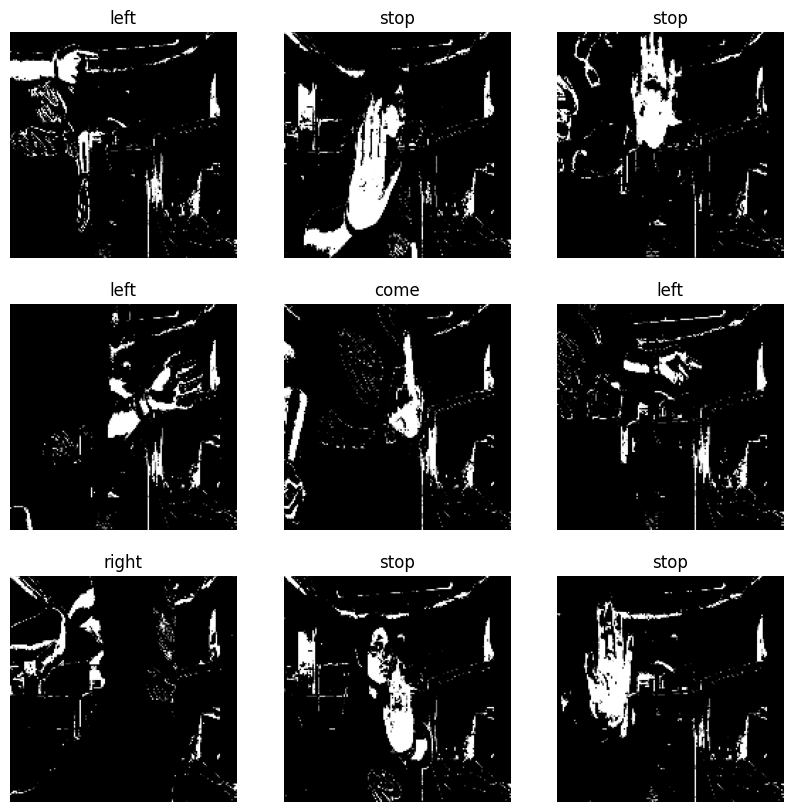

In [ ]:
plt.figure(figsize=(10,10))
for images, labels in train_dataset.take(1):
  print(images.shape)
  for i in range(9):
    ax = plt.subplot(3,3,i+1)
    plt.imshow(images[i].numpy().astype('uint8'))
    plt.title(class_names[labels[i]])
    plt.axis('off')

We are spliting batches into validation and test.

In [ ]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches//5)
validation_dataset = validation_dataset.skip(val_batches//5)


In [ ]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 34
Number of test batches: 8


We use built in autotune for buffer sizes

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

## Data Augmentation: flipping vertically and small degree rotation

In [ ]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip('vertical'), #cannot use horizontal because it will ruin left right
    tf.keras.layers.RandomRotation(0.1)
])

## Reshape the images into the format of the pretrained neural network input

In [ ]:
preprocess_input = tf.keras.applications.inception_resnet_v2.preprocess_input

# Model Build Up
Base model: inception_resnet_v2

In [ ]:
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.InceptionResNetV2(input_shape=IMG_SHAPE,
                                                     include_top=False,
                                                     weights='imagenet')

In [ ]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 3, 3, 2048)


## Making the base model weights untrainable

In [ ]:
#freeze BatchNormalization from updating its mean and variance statistics
base_model.trainable = False

# base_model.summary();

## Adding customized output layers
- global average pooling - average over the spatial locations, convert features to a vector per image
- dropout - randomly delete some connections between the 2 layers to avoid overfitting
- dense - makes feature vector into the output shape of our choice (4 in our model, each representing the possibility of corresponding class)
- Activation function: `softmax` because it is generally used for multilabel classification

In [ ]:
#average over the spatial locations, convert features to a vector per image
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 2048)


In [ ]:
# use dense layer to make vector into 1 prediction
prediction_layer = tf.keras.layers.Dense(num_classes, activation='softmax')
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 4)


In [ ]:
inputs = tf.keras.Input(shape=(160,160,3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.4)(x)
outputs= prediction_layer(x)


## Add early stopping
Saves time and avoids overfitting: if no significant improvement in 3 epochs, just stop the training

In [ ]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)

## Model Complilation:
We set learning rate, decay rate, optimizer and loss function.

In [ ]:
base_learning_rate = 0.0001
base_decay_rate = 0.001
with tf.device(device_name):
  model = tf.keras.Model(inputs,outputs)
  model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = base_learning_rate,decay = base_decay_rate),
              loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'],
  )

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 160, 160, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 160, 160, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 160, 160, 3)      0         
 a)                                                              
                                                                 
 inception_v3 (Functional)   (None, 3, 3, 2048)        21802784  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0     

Start to train 10 epochs with only the output layers adjustable

In [ ]:
initial_epochs = 10
with tf.device(device_name):
    loss0, accuracy0 = model.evaluate(validation_dataset)

34/34 [==============================] - 9s 216ms/step - loss: 2.4330 - accuracy: 0.3277


In [ ]:
print('initial loss:{:.2f}'.format(loss0))
print('initial accuracy:{:.2f}'.format(accuracy0))

initial loss:2.43
initial accuracy:0.33


In [ ]:
with tf.device(device_name):
    history = model.fit(train_dataset,
                    epochs= initial_epochs,
                    validation_data= validation_dataset,
                    callbacks=callback
                    )

Epoch 1/10
97/97 [==============================] - 38s 348ms/step - loss: 2.0817 - accuracy: 0.3215 - val_loss: 1.6092 - val_accuracy: 0.3538
Epoch 2/10
97/97 [==============================] - 41s 420ms/step - loss: 1.6793 - accuracy: 0.4111 - val_loss: 1.5549 - val_accuracy: 0.3855
Epoch 3/10
97/97 [==============================] - 44s 452ms/step - loss: 1.4776 - accuracy: 0.4704 - val_loss: 1.4756 - val_accuracy: 0.4209
Epoch 4/10
97/97 [==============================] - 43s 439ms/step - loss: 1.4089 - accuracy: 0.4952 - val_loss: 1.4547 - val_accuracy: 0.4264
Epoch 5/10
97/97 [==============================] - 43s 443ms/step - loss: 1.3028 - accuracy: 0.5370 - val_loss: 1.3883 - val_accuracy: 0.4507
Epoch 6/10
97/97 [==============================] - 42s 430ms/step - loss: 1.1838 - accuracy: 0.5693 - val_loss: 1.4225 - val_accuracy: 0.4460
Epoch 7/10
97/97 [==============================] - 43s 440ms/step - loss: 1.1521 - accuracy: 0.5718 - val_loss: 1.4169 - val_accuracy: 0.4628

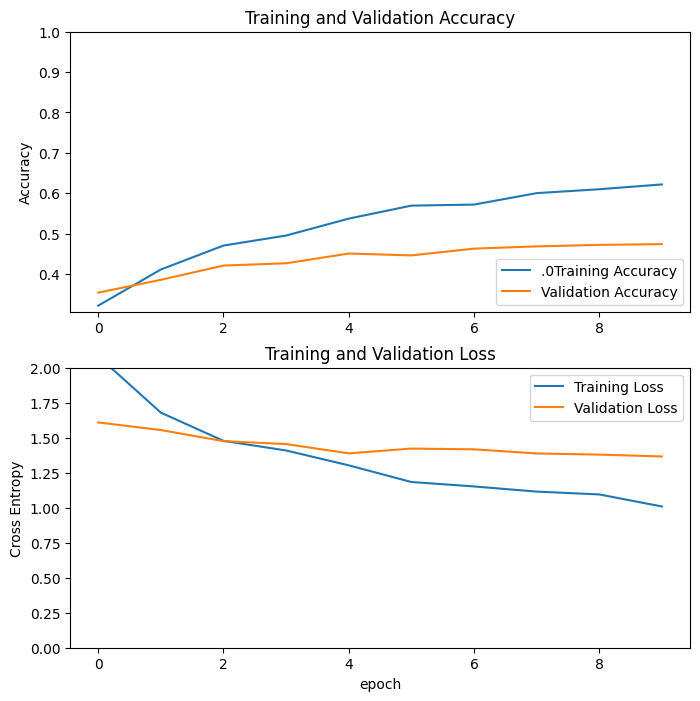

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='.0Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,2.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

We could see form the plot that our model was making progress.

# Fine Tuning Base Model
We first set the base model all trainable, then freeze the layers that we want to keep steady.

In [ ]:
base_model.trainable = True

In [ ]:
print("Number of layers in the base model: ", len(base_model.layers))
fine_tune_at = 100
for layer in base_model.layers[:fine_tune_at]:
      layer.trainable = False

Number of layers in the base model:  311


Since there are more variables to train, especially they are all pre-trained, we set lower learning and decay rate just to make sure not to mess up.

In [ ]:
with tf.device(device_name):
    model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10,decay = base_decay_rate/10),
              metrics=['accuracy'])

In [ ]:
len(model.trainable_variables)


130

In [ ]:
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset,
                         callbacks=callback
                         )

Epoch 10/20
97/97 [==============================] - 97s 894ms/step - loss: 0.7486 - accuracy: 0.7178 - val_loss: 0.2888 - val_accuracy: 0.9134
Epoch 11/20
97/97 [==============================] - 88s 900ms/step - loss: 0.2660 - accuracy: 0.9062 - val_loss: 0.1025 - val_accuracy: 0.9711
Epoch 12/20
97/97 [==============================] - 89s 912ms/step - loss: 0.1498 - accuracy: 0.9462 - val_loss: 0.0579 - val_accuracy: 0.9786
Epoch 13/20
97/97 [==============================] - 85s 875ms/step - loss: 0.0922 - accuracy: 0.9671 - val_loss: 0.0892 - val_accuracy: 0.9786
Epoch 14/20
97/97 [==============================] - 87s 894ms/step - loss: 0.0633 - accuracy: 0.9794 - val_loss: 0.0445 - val_accuracy: 0.9907
Epoch 15/20
97/97 [==============================] - 87s 900ms/step - loss: 0.0427 - accuracy: 0.9832 - val_loss: 0.0283 - val_accuracy: 0.9926
Epoch 16/20
97/97 [==============================] - 86s 886ms/step - loss: 0.0382 - accuracy: 0.9855 - val_loss: 0.0244 - val_accuracy:

In [ ]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

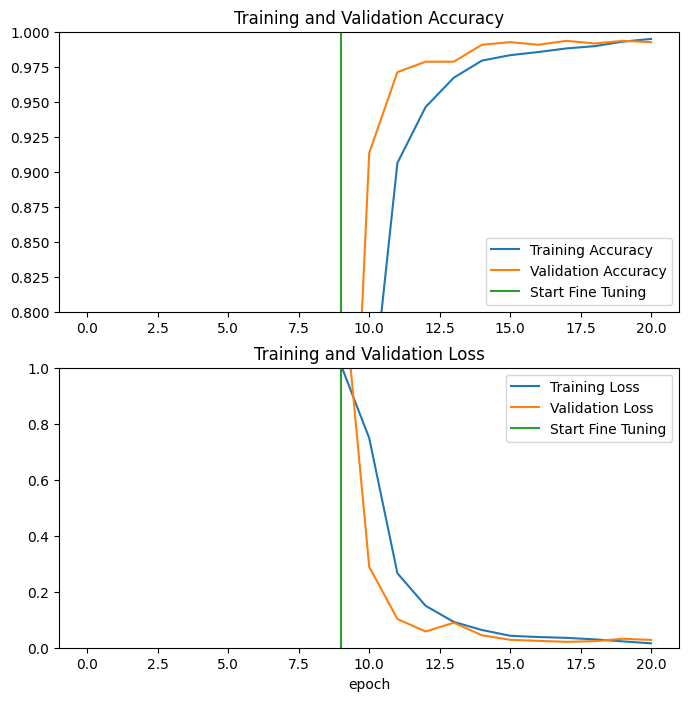

In [ ]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

No overfitting or underfitting, it's a pretty good model.

In [ ]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

8/8 [==============================] - 3s 303ms/step - loss: 0.0380 - accuracy: 0.9766
Test accuracy : 0.9765625


In [ ]:
model.save(os.getcwd() + '/model_inception_resnet_v2')
